In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
labels = ['Grape_Black_rot','Esca','Grape_healthy','Grape_Leaf_blight']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        print(f"path = {path}")
        class_num = labels.index(label)
        print(f"path = {path}")
        print(f"class_num = {class_num}")
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [3]:
data = get_data(r'K:\set\Grape')  #enter yours

path = K:\set\Grape\Grape_Black_rot
path = K:\set\Grape\Grape_Black_rot
class_num = 0
path = K:\set\Grape\Esca
path = K:\set\Grape\Esca
class_num = 1
path = K:\set\Grape\Grape_healthy
path = K:\set\Grape\Grape_healthy
class_num = 2
path = K:\set\Grape\Grape_Leaf_blight
path = K:\set\Grape\Grape_Leaf_blight
class_num = 3


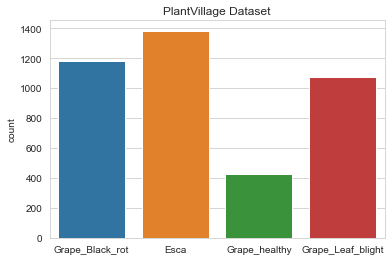

<Figure size 640x160 with 0 Axes>

In [4]:
from matplotlib.pyplot import figure
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('whitegrid')
sns.countplot(l)
plt.title('PlantVillage Dataset', fontweight = 30)

figure(num=None, figsize=(8, 2), dpi=80, facecolor='w', edgecolor='k')
plt.show()

In [5]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [6]:
x = np.array(x) / 255

In [7]:
y = np.array(y)
y[:5]

array([0, 0, 0, 0, 0])

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , random_state = 0)

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [11]:
pre_trained_model = VGG16(input_shape=(150,150,3), include_top=False, weights="imagenet")
pre_trained_model.trainable = False
    
model = Sequential([
    pre_trained_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(4 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 14,722,884
Trainable params: 8,196
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) , 
                    epochs = 25 , 
                    validation_data = (x_test, y_test))

Epoch 1/25
26/26 [==============================] - 47s 2s/step - loss: 1.1506 - accuracy: 0.5103 - val_loss: 0.7399 - val_accuracy: 0.7700
Epoch 2/25
 3/26 [==>...........................] - ETA: 15s - loss: 0.7284 - accuracy: 0.7708

In [ ]:
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(f"path = {path}")
        print(f"class_num = {class_num}")
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0] , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs(dönem)")
ax[0].set_ylabel("Accuracy(doğruluk)")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs(dönem)")
ax[1].set_ylabel("Loss(kayıp)")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm = pd.DataFrame(cm , index = labels , columns = labels)

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm,cmap= "tab20c", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)
plt.show()

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==150):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
count=0
fig,ax=plt.subplots(2,2)
fig.set_size_inches(20,20)
for i in range (2):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Tahmin Edilen : "+ labels[predictions[prop_class[count]]] +"\n"+"Gerçek Hastalık : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1
plt.show()
